In [1]:
import pandas as pd
import numpy as nm
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
import csv
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, StandardScaler, PCA
from pyspark.ml.classification import DecisionTreeClassifier

In [2]:
from decision_tree_plot.decision_tree_parser import decision_tree_parse
from decision_tree_plot.decision_tree_plot import plot_trees

---

## Initialize a SparkSession, define the csv Schema

In [3]:
ss = SparkSession.builder.appName("Project").getOrCreate()

In [4]:
schema = StructType([ StructField("ID", IntegerType(), False ), \
                        StructField("Case Number", StringType(), False), \
                        StructField("Date", StringType(), False ), \
                        StructField("Block", StringType(), False ), \
                        StructField("IUCR", StringType(), False), \
                        StructField("Primary Type", StringType(), False), \
                        StructField("Description", StringType(), False),\
                        StructField("Location Description", StringType(), False), \
                        StructField("Arrest", StringType(), False), \
                        StructField("Domestic", StringType(), False), \
                        StructField("District", StringType(), False) ,\
                        StructField("Ward", StringType(), False ), \
                        StructField("Community Area", StringType(), False ), \
                        StructField("FBI Code", StringType(), False), \
                        StructField("Year", StringType(), False), \
                        StructField("Latitude", StringType(), False),\
                        StructField("Longitude", StringType(), False)
                           ])

In [5]:
# new_file3.csv is the file generated by using Suvarna's code
data = ss.read.csv("./new_file3.csv",schema=schema,header=True, inferSchema=False)

In [6]:
data = data.drop('Case Number').drop('ID')

---

## Apply PCA Reduction
#### Reason: I tried directly using Lab8's code before. However, I continously got an error saying the data's cardinality is too high and aborted the task, which means the dataset's size is too large. To reduce the dataset's size, I need to use PCA reduction first to reduce the size and then use the reduced data to train the model.

`Step 1: Transforms a column of string to a new column of index (type double)`

In [7]:
# This block will create a new column for each indexed column, for example, will create a 'i_date' for indexed 'Date' column
columns_to_index = ["Date", "Primary Type", "Description", "IUCR","Year","Block",
                    "Location Description", "Arrest", "Domestic", "District","Ward","FBI Code","Community Area", 
                    "Latitude", "Longitude"]
label_indexers = {col: StringIndexer(inputCol=col, outputCol=f"i_{col.replace(' ', '_').lower()}").fit(data) for col in columns_to_index}

In [8]:
# This block will transform data
transformed_data = data
for indexer in label_indexers.values():
    transformed_data = indexer.transform(transformed_data)

In [9]:
# data2 will contain the indexed values only, which means they are all integer -> ready for training
data2 = transformed_data.select("i_date","i_iucr","i_primary_type","i_description","i_location_description",\
                    "i_arrest","i_year","i_block","i_domestic","i_district","i_ward","i_fbi_code","i_community_area","i_latitude","i_longitude")

In [10]:
input_features = ["i_date","i_iucr","i_primary_type","i_description","i_location_description","i_year","i_block",\
                    "i_domestic","i_district","i_ward","i_fbi_code","i_community_area","i_latitude","i_longitude"]

`Step 2: Create a vector-assembler to combine individual features into a vector in a new column, which called 'features_for_arrest'.`

In [11]:
assembler = VectorAssembler(inputCols=input_features, outputCol="features_for_arrest")

In [12]:
assembled_data = assembler.transform(data2)

`Step 3: Use a StandardScaler to center the data - saved the centered data into a new column called "scaled_features"`

In [13]:
scaler = StandardScaler(inputCol="features_for_arrest", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [14]:
# When k=9, its variance is closest to 0.9 && > 0.9
pca = PCA(k=9,inputCol="scaled_features",outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)
explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  0.9064204185937148


`By that, We got the PCA reduction data: result `

---

## Train the model

####  Train the model with the reduced data. I used sklearn instead of PySpark DecisionTree.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [16]:
# Convert PySpark DataFrame to Pandas DataFrame
# "pcaFeatures" is the hyperparameter that predicts arrest or not
# "i_arrest" is our target variable
pandas_df = result.select("pcaFeatures", "i_arrest").toPandas()

In [17]:
# Extract PCA features and target variable
X = pandas_df["pcaFeatures"].tolist()
y = pandas_df["i_arrest"].tolist()

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
# Standardize the data again just in case
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

`Above is the model that predicts the value of Arrest`

In [21]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

---

## Evaluate the model (Don't run the code until testing phase)

In [22]:
# Use test_data to evaluate our model 
'''
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))
'''

'\naccuracy = accuracy_score(y_test, predictions)\nprint("Accuracy: {:.2f}%".format(accuracy * 100))\n'

## Suvarna

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [24]:
def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    column_name: column name (string) that indicates which vector of features to choose
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Assemble the features into a vector column
    assembler = VectorAssembler(inputCols=[column_name], outputCol='features')
    df_assembled = assembler.transform(df_input)
    
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_assembled)
       
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_assembled)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    
    # Get the cluster sizes and centers
    cluster_sizes = clustered_data.groupBy("prediction").count()
    cluster_sizes.show()
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

In [25]:
num_centers = 2
clustered_data, _, _ = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+------+
|prediction| count|
+----------+------+
|         1|109818|
|         0|242548|
+----------+------+



In [26]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the indices for the cluster center
    p1 = feature_columns.index(feature_1)
    p2 = feature_columns.index(feature_2)
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        # Generate a random color
        random_color = generate_random_color()        
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], color=[random_color], label=f'Cluster {cluster_id}')
        plt.scatter(cluster_data.mean(),cluster_data.mean(), color=[random_color], marker='x', s=500)
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

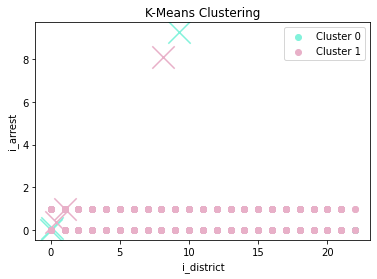

In [27]:
import random
import matplotlib.pyplot as plt

feature_columns = data2.columns
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "i_district"
feature_2 = "i_arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

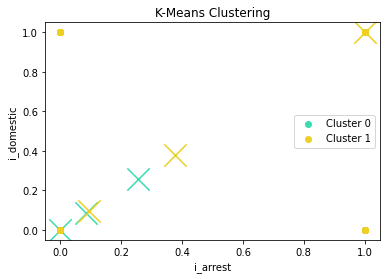

In [28]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "i_arrest"
feature_2 = "i_domestic"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

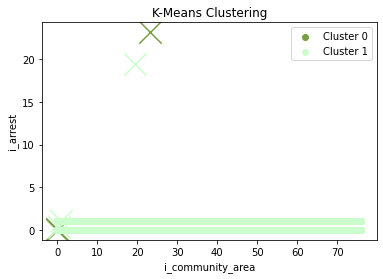

In [29]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "i_community_area"
feature_2 = "i_arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

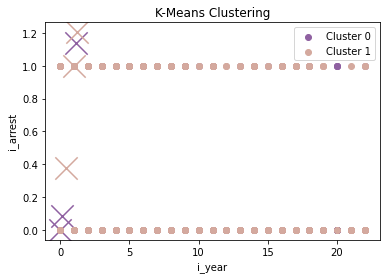

In [30]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "i_year"
feature_2 = "i_arrest"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)